In [1]:
from IPython import get_ipython
import os

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab, installing requirements...")
    # URL of the requirements file
    requirements_url = "https://raw.githubusercontent.com/willdalh/ml-course/main/requirements.txt"

    # Check if the requirements file already exists
    if not os.path.exists('requirements.txt'):
        # Download the requirements file
        !wget {requirements_url}

    # Install the requirements
    !python -m pip install --user -q -r requirements.txt

In [ ]:
import sys
sys.path.append("../")

## AutoEncoder

AutoEncoder er en nettverksarkitektur som rekonstruerer input fra en lav-dimensjonell representasjon av input. Input er for eksempel pikslene på et bilde. Disse går gjennom en serie nettverkslag som reduserer antall features, frem til man når en flaskehals. Fra flaskehalsen skal modellen så gjenskape det som var i input. 

<img src="../res/autoencoder.png" height="300px">

In [2]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

En AutoEncoder består av to komponenter:
- Encoder
    - En sekvens med lineære lag som reduserer dimensjonaliteten.
    - Ender opp med en vektor med veldig få dimensjoner kontra 784 fra rådata.
- Decoder
    - En sekvens med lineære lag som rekonstruerer inputten fra den korte vektoren.

Vi tar i bruk `nn.Sequential` for å lage sekvenser av lag som dataen flyter gjennom.

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=16):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=200),
            nn.Tanh(),
            nn.Linear(in_features=200, out_features=42),
            nn.Tanh(),
            nn.Linear(in_features=42, out_features=bottleneck_size),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
             nn.Linear(in_features=bottleneck_size, out_features=42),
             nn.Tanh(),
             nn.Linear(in_features=42, out_features=200),
             nn.Tanh(),
             nn.Linear(200, 28*28),
             nn.Tanh()
        )

    def encode(self, data):
        out = torch.flatten(data, start_dim=1, end_dim=-1)
        out = self.encoder(out)
        return out
    
    def decode(self, data):
        out = self.decoder(data)
        return out.reshape(-1, 1, 28, 28)

    def forward(self, data):
        out = self.encode(data)
        out = self.decode(out)
        return out
    
autoencoder = AutoEncoder(bottleneck_size=32)
autoencoder.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=42, bias=True)
    (3): Tanh()
    (4): Linear(in_features=42, out_features=32, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=42, bias=True)
    (1): Tanh()
    (2): Linear(in_features=42, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='../data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='../data', train=False, transform=image_processing, download=True) # Test data for later
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) 

In [16]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, _) in enumerate(pbar): # no need for labels
            data = data.to(device)
            pred = autoencoder.forward(data) # Query model for predictions
            loss = loss_fn(pred, data)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients



Epoch 9: 100%|██████████| 1875/1875 [00:08<00:00, 226.60batch/s]


Vi studerer nå hvordan modellen klarer å rekonstruere et siffer fra datasettet.

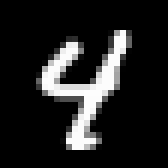

In [6]:
from utils.visualize import visualize

rand_index = torch.randint(0, len(test_dataset), (1,)).item()
data_sample, label_sample = test_dataset[rand_index]

visualize(data_sample)

In [7]:
encoding = autoencoder.encode(data_sample.unsqueeze(0).to(device)) # Add batch dimension
encoding
print(encoding.shape)
print(encoding)
visualize(encoding.unsqueeze(0))

torch.Size([1, 32])
tensor([[-0.2683, -0.0901,  0.1352, -0.1284,  0.0341,  0.3011,  0.0492, -0.2790,
          0.1196, -0.0837,  0.6147,  0.2447,  0.1780, -0.3403, -0.2461,  0.2670,
         -0.0161, -0.0490, -0.0608, -0.1727, -0.2258,  0.3602, -0.1427,  0.1317,
         -0.0567,  0.4090, -0.1206, -0.5092,  0.3619, -0.0741,  0.1640,  0.1304]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [8]:
encoding

tensor([[-0.2683, -0.0901,  0.1352, -0.1284,  0.0341,  0.3011,  0.0492, -0.2790,
          0.1196, -0.0837,  0.6147,  0.2447,  0.1780, -0.3403, -0.2461,  0.2670,
         -0.0161, -0.0490, -0.0608, -0.1727, -0.2258,  0.3602, -0.1427,  0.1317,
         -0.0567,  0.4090, -0.1206, -0.5092,  0.3619, -0.0741,  0.1640,  0.1304]],
       device='cuda:0', grad_fn=<TanhBackward0>)

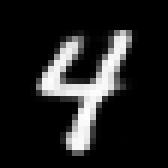

In [9]:
decoding = autoencoder.decode(encoding)
visualize(decoding.squeeze(0))

Ved å ha en flaskehals i midten av nettverket, har modellen lært seg en lav-dimensjonell representasjon av sifrene.

Det morsomme er at decoder-delen av nettverket kan anvendes som en generativ modell. Inputtet vil være en vektor av lav dimensjon. Vi har også brukt `Tanh` som aktiveringsfunksjon på output fra encoderen, som betyr at decoderen alltid vil forvente tall som ligger i $\langle-1, 1\rangle$. 

Hvis vi generer en 16-dimensjonal vektor med tilfeldige tall, og bruker dette som input til decoderen, får vi et _syntetisk_ siffer som output. Den 16-dimensjonale vektoren vil i faglitteraturen kalles for en _latent_ representasjon av et siffer.

Jeg skrev [masteroppgaven min](https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/3095628) om latente representasjoner i diffusjonsmodeller. Bare ta en titt 😄

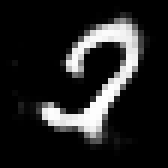

In [10]:
latent = (torch.rand(size=(1, autoencoder.bottleneck_size))-0.5)*2
decoding = autoencoder.decode(latent.to(device))
visualize(decoding.squeeze(0))

Resultatene gjenspeiler den enkle arkitekturen som er valgt, og fåtallet epoker den fikk trene.